# Introduction to Machine Learning - HW3

>[Introduction to Machine Learning - HW3](#scrollTo=XXFbOU5Kp6qV)

>>[Preliminary: Updated Data Loading](#scrollTo=WuPHg0BgqW3l)

>>>[a. Loading the data](#scrollTo=WuPHg0BgqW3l)

>>>[b. Splitting the Dataset](#scrollTo=mi3TiL7jqm7Y)

>>>[c. preprocessing](#scrollTo=iMiPW7Pbq-FB)

>>[Section 1: Linear regression implementation](#scrollTo=cNWcDE57W8Vx)

>>>[Question 1 - LinearRegressor Implementation](#scrollTo=UiCTKNiQW_Uf)

>>>[Question 2 - Verify Gradients](#scrollTo=U9jRXZ8JdKRl)

>>>[Question 3 - Test LR](#scrollTo=BREpxr3ojmUf)

>>[Section 2: Evaluation and Baseline](#scrollTo=Y5ndrOz0mwUG)

>>>[Question 4 - DummyRegressor](#scrollTo=XpYsfK91m1LU)

>>>>[Basic hyperparameter tuning](#scrollTo=XTnM-Nc5qGhf)

>>>[Question 5 - LinearRegressor with the tuning lr](#scrollTo=SW8j9a3-6uMg)

>>[Section 3: Linear regression with Lasso](#scrollTo=z6RLzNUI819Y)

>>>[Question 7 - Tune the regularization strength of Lasso](#scrollTo=zQ-Ohqlt9CJd)

>>>[Question 8 - LassoRegressor with the tuning lr](#scrollTo=sY0whmudHeOu)

>>>[Question 9 -  largest coefficients (in absolute value) in the resulting regressor](#scrollTo=TLpU06TxJQ_e)

>>>[Question 10 -  Plotting coefficients](#scrollTo=6YoSJapdLaLD)

>>[Section 4: Polynomial fitting (visualization)](#scrollTo=_GJD-dDwNQ8N)

>>>[Question 10 - 3-d plot](#scrollTo=weHo5UphOJyW)

>>>[Question 14 - Lasso classifier as baseline](#scrollTo=-h9bR2OWPoE-)

>>>[Question 15 - 3d plot of thr Lasso baseline](#scrollTo=zDE6WwnmROK-)

>>[Section 5: RandomForest fitting of the CovidScore](#scrollTo=AQaPBRAGWLoQ)



## Preliminary: Updated Data Loading
### a. Loading the data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from google.colab.data_table import DataTable

DataTable.max_columns = 40
!rm *.csv

print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]

dataset = pd.read_csv(filename)
dataset.shape

rm: cannot remove '*.csv': No such file or directory
Please load the raw csv data


Saving HW3_data.csv to HW3_data.csv


(1250, 25)

### b. Splitting the Dataset

In [ ]:
from sklearn.model_selection import train_test_split

random_state = (47 + 33)
test_size = 0.2
train, test = train_test_split(dataset, test_size=test_size, random_state=random_state)

print(train.shape, test.shape)

(1000, 25) (250, 25)


### c. preprocessing

In [ ]:
# ===== Module Description:

"""
# Data Preparation Pipeline
This module provides preparation pipeline of data from the covid-19
dataset.
Example:
--------
data_prep = data_preparation(training_data, new_data)
data_prep.prepare()
"""


# ====================
# ===== Imports:

import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# ====================

class data_preparation():
    """
    data_preparation class.
    -------
    Attributes
    -------
    - new_dataset : pandas.DataFrame
            Dataframe to prepare

    - training_data_ref : pandas.DataFrame
            Dataframe to prepare by

    - symptoms_per_patient : list
             List of possible symptoms from training_data_ref "symptoms" feature

    -------
    Protected Methods
    -------
    __seperate_blood_groups(dataset)
    __seperate_symptoms(dataset)
    __seperate_location(dataset)
    __replace_sex(dataset)
    __replace_pcr_date(dataset)
    __normalize()
    -------
    Public Methods
    -------
    prepare()
        Returns the prepared data.

    """
    def __init__(self, training_data, new_data):
        self.new_dataset = new_data.copy()
        self.training_data_ref = training_data.copy()
        self.symptoms_per_patient = [x.split(';') for x in self.training_data_ref["symptoms"] if x is not np.nan]

        self.__seperate_blood_groups(self.training_data_ref)
        self.__seperate_symptoms(self.training_data_ref)
        self.__seperate_location(self.training_data_ref)
        self.__replace_sex(self.training_data_ref)
        self.__replace_pcr_date(self.training_data_ref)


    def __seperate_blood_groups(self, dataset):
    # Groups we seperate by
        blood_groups = {'A': ['A+', 'A-'],
                                        'O': ['O-', 'O+'],
                                        'B/AB': ['B+', 'B-', 'AB+', 'AB-']}

        for type, blood_group in blood_groups.items():
                # Creating the mew features
                feature = dataset["blood_type"].isin(blood_group).astype(int)
                # Inserting the new features
                dataset['blood_group_' + type] = feature

        # Drop the old blood_type feature
        dataset.drop('blood_type', inplace=True ,axis=1)
        return dataset


    def __seperate_symptoms(self, dataset):
        symptoms = list({x for l in self.symptoms_per_patient for x in l})

        for symptom in symptoms:
            feature = []
            for sample in dataset["symptoms"]:
                if sample is np.nan or symptom not in sample:
                    feature.append(0)
                else:
                    feature.append(1)

            dataset['symptom_' + symptom] = feature

        # Drop the old symptoms feature    
        dataset.drop('symptoms', inplace=True ,axis=1)
        return dataset


    def __seperate_location(self, dataset):
        # Drop the old current_location feature and adding x_coor and y_coor
        dataset['x_global_coor'] = [float(x.split("'")[1]) for x in dataset['current_location']]
        dataset['y_global_coor'] = [float(x.split("'")[3]) for x in dataset['current_location']]

        dataset.drop(['current_location'], inplace=True, axis=1)
        return dataset


    def __replace_sex(self, dataset):
        # Replace sex with binary is_male & Drop the old current_location
        dataset['sex'] = dataset['sex'].isin(['F']).astype(int)
        return dataset


    def __replace_pcr_date(self, dataset):
        # Drop the old pcr_date feature and replace
        dataset['pcr_date_numeric'] = [int(datetime.strptime(date, '%Y-%m-%d').timestamp()) for date in dataset['pcr_date']]

        dataset.drop(['pcr_date'], inplace=True, axis=1)
        return dataset


    def __normalize(self):
        all_features = list(self.new_dataset.columns)
        all_features.remove('contamination_level')

        mm_features = ['patient_id', 'num_of_siblings', 'happiness_score',
                                    'sport_activity', 'pcr_date_numeric', 'PCR_01', 'PCR_02', 'PCR_03',
                                    'PCR_04', 'PCR_05', 'PCR_07', 'PCR_09', 'y_global_coor']

        for feature in all_features:
            if feature in mm_features:
                mm_scaler = MinMaxScaler(feature_range=(-1, 1))
                mm_scaler.fit(self.training_data_ref[[feature]])
                self.new_dataset[[feature]] = mm_scaler.transform(self.new_dataset[[feature]])
            else:
                ss_scaler = StandardScaler()
                ss_scaler.fit(self.training_data_ref[[feature]])
                self.new_dataset[[feature]] = ss_scaler.transform(self.new_dataset[[feature]])
        return self.new_dataset


    def prepare(self):
        self.__seperate_blood_groups(self.new_dataset)
        self.__seperate_symptoms(self.new_dataset)
        self.__seperate_location(self.new_dataset)
        self.__replace_sex(self.new_dataset)
        self.__replace_pcr_date(self.new_dataset)
        self.__normalize()

        return self.new_dataset

def preprare_data(training_data, new_data):
    data_prep = data_preparation(training_data, new_data)
    return data_prep.prepare()


In [ ]:
prep_train = preprare_data(train,train)
prep_test = preprare_data(train,test)

## Section 1: Linear regression implementation

### Question 1 - LinearRegressor Implementation

In [ ]:
# Split the test set for test-valuation
val_size = 0.2
sec1_train, sec1_val = train_test_split(prep_train, test_size=test_size, random_state=random_state)

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """
        loss = (X.dot(w) + b - y)
        norm_squard = np.power(np.linalg.norm(loss), 2)

        return norm_squard / X.shape[0]

    @staticmethod
    def gradient(w, b: float, X, y):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        m = X.shape[0]
        inner_deriv = (X.dot(w) + b - y)
        g_w = (2 / m) * X.T.dot(inner_deriv)
        g_b = (2 / m) * np.sum(inner_deriv)

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y)

            # Perform a gradient step
            self.w = self.w - (self.lr * g_w)
            self.b = self.b - (self.lr * g_b)

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """
        return X.dot(self.w) + self.b

### Question 2 - Verify Gradients

In [ ]:
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


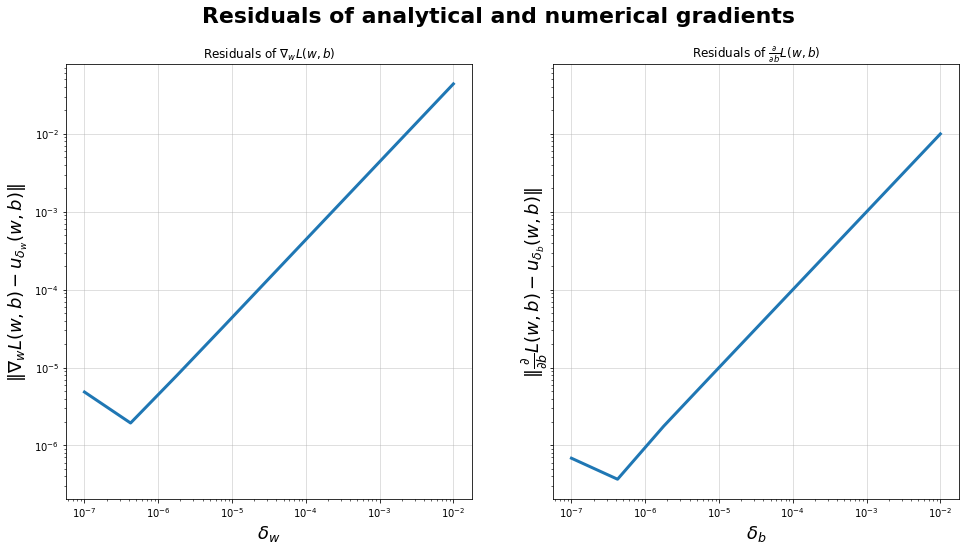

In [ ]:
X_train = sec1_train.copy()
X_train.drop(["contamination_level"], inplace=True, axis=1)
y_train = np.array(sec1_train.contamination_level)

compare_gradients(X_train, y_train, deltas=np.logspace(-7, -2, 9))

### Question 3 - Test LR

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)
  
  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

lr size = 1e-09, Best train loss = 391.1413791762018, Best validation loss = 409.9638071021028
lr size = 1e-08, Best train loss = 391.11261638072244, Best validation loss = 409.93444598274306
lr size = 1e-07, Best train loss = 390.82514899457607, Best validation loss = 409.6409940456196
lr size = 1e-06, Best train loss = 387.96647136873105, Best validation loss = 406.72234134878704
lr size = 1e-05, Best train loss = 360.92038250360486, Best validation loss = 379.0651335871503
lr size = 0.0001, Best train loss = 199.26550468109798, Best validation loss = 211.22666399766607
lr size = 0.001, Best train loss = 101.19666125976865, Best validation loss = 101.57747979526084
lr size = 0.01, Best train loss = 96.70168316161386, Best validation loss = 96.82676358218879
lr size = 0.1, Best train loss = 100.6227308948572, Best validation loss = 100.024971009103


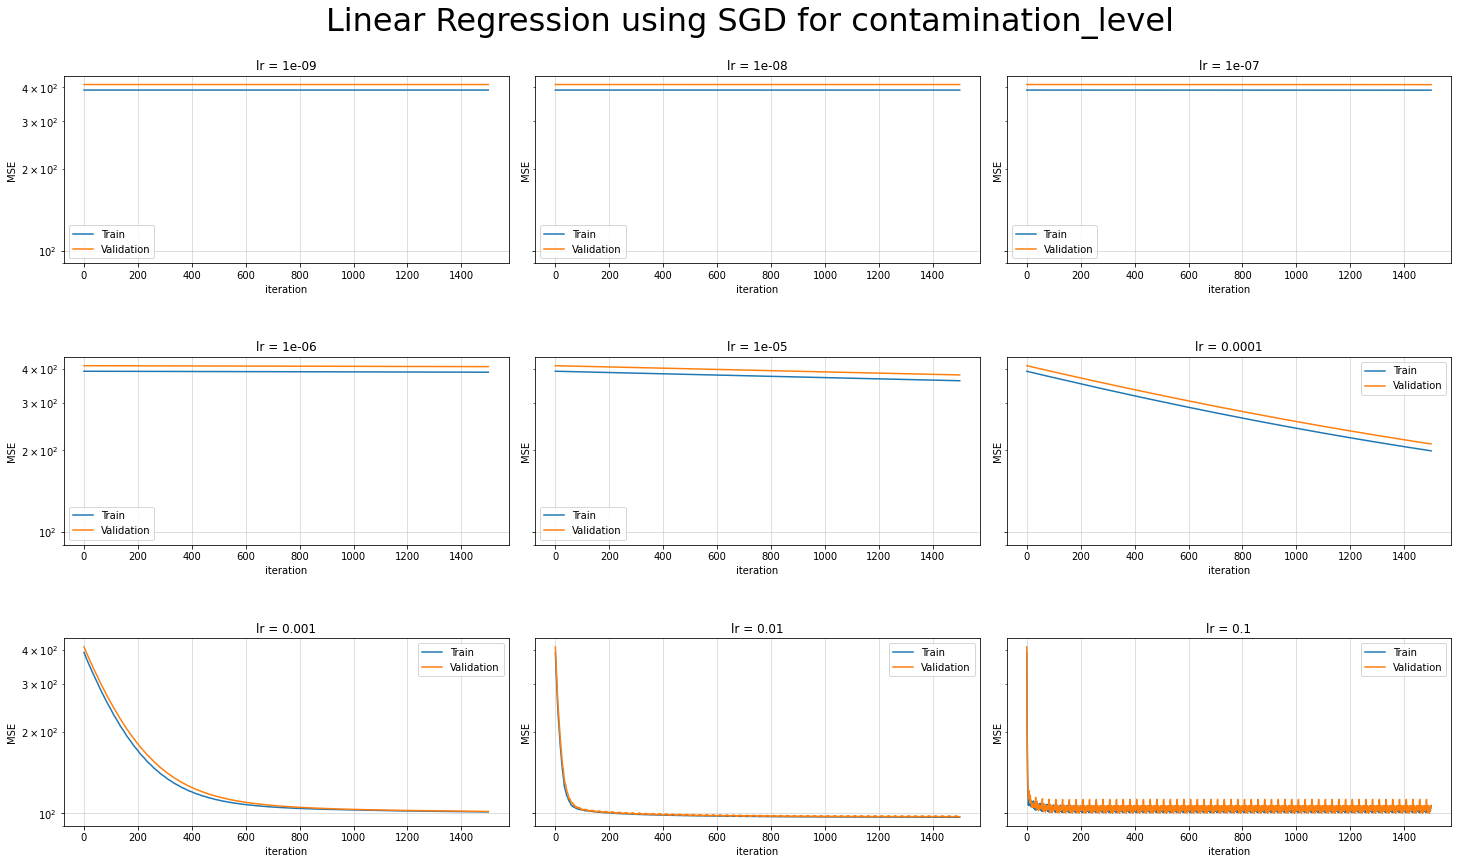

In [ ]:
X_train = sec1_train.copy()
X_train.drop(["contamination_level"], inplace=True, axis=1)
y_train = np.array(sec1_train.contamination_level)

X_val = sec1_val.copy()
X_val.drop(["contamination_level"], inplace=True, axis=1)
y_val = np.array(sec1_val.contamination_level)

test_lr(X_train, y_train, X_val, y_val, "Linear Regression using SGD for contamination_level")

## Section 2: Evaluation and Baseline

### Question 4 - DummyRegressor

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate

X_train = prep_train.copy()
X_train.drop(["contamination_level"], inplace=True, axis=1)
y_train = np.array(prep_train.contamination_level)

dr = DummyRegressor(strategy='mean')
cv = cross_validate(estimator=dr, X=X_train, y=y_train, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
cv_dummy_va = cv['test_score'].mean()
print(f"Train Error {cv['train_score'].mean()}")
print(f"Validation Error {cv['test_score'].mean()}")

Train Error -106.5640324839979
Validation Error -106.80977716784801


DummyRegressor for Section 6 

In [ ]:
X_train = prep_train.copy()
X_train.drop(["contamination_level"], inplace=True, axis=1)
y_train = np.array(prep_train.contamination_level)

dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train, y_train)

DummyRegressor()

#### Basic hyperparameter tuning
Finding the optimal lr for the LinearRegressor

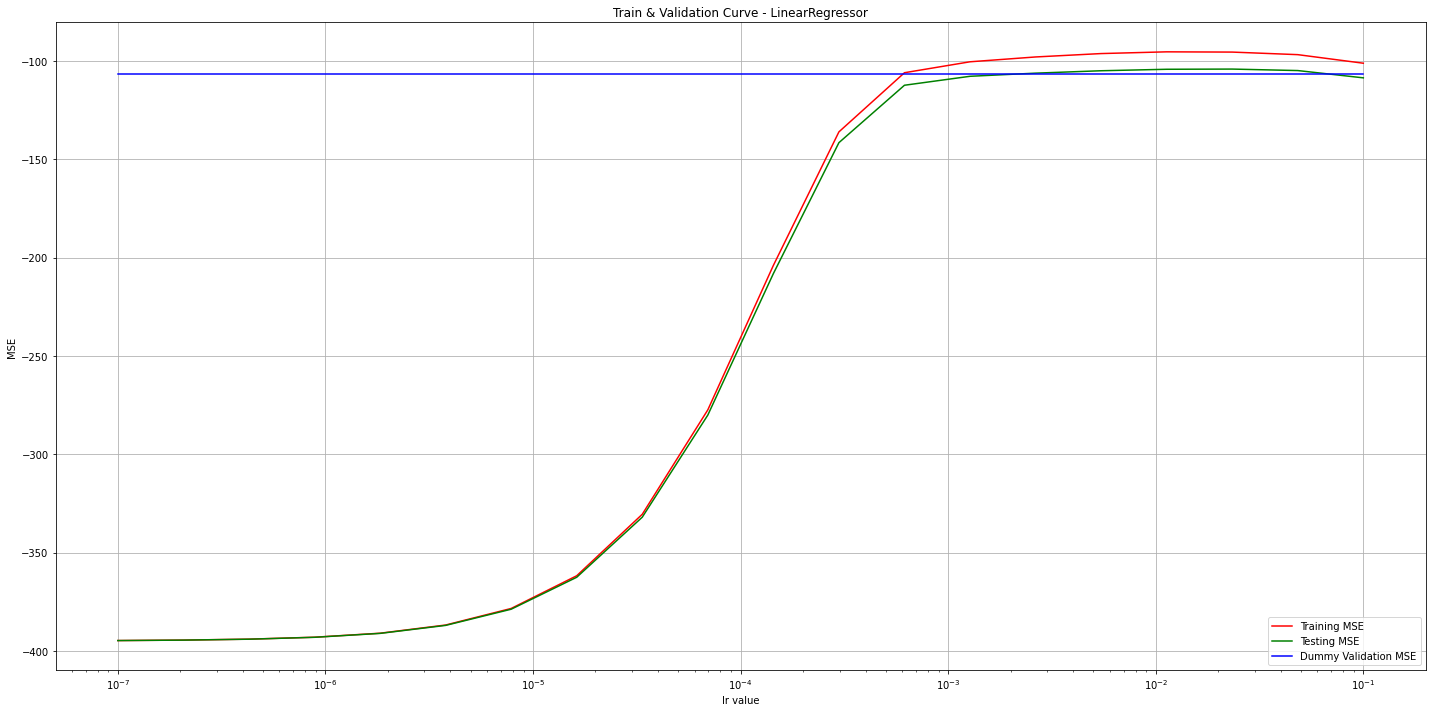

In [ ]:
X_train = prep_train.copy()
X_train.drop(["contamination_level"], inplace=True, axis=1)
y_train = np.array(prep_train.contamination_level)

train_list, test_list = [], []
rng = np.logspace(-7, -1, 20)

for lr in rng:
  lreg = LinearRegressor(lr)
  cv = cross_validate(estimator=lreg, X=X_train, y=y_train, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
  train_list.append(cv['train_score'].mean())
  test_list.append(cv['test_score'].mean())

plt.figure(figsize=(20,10))
plt.plot(rng, train_list, label="Training MSE", color="red")
plt.plot(rng, test_list, label="Testing MSE", color="green")
plt.plot(rng, [cv_dummy_va for _ in rng], label="Dummy Validation MSE", color="blue")
plt.semilogx()
plt.title("Train & Validation Curve - LinearRegressor")
plt.xlabel("lr value")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.show()

### Question 5 - LinearRegressor with the tuning lr

In [ ]:
print(f"Best lr: {rng[np.argmax(test_list)]}")
print(f"Best lr mean train accuracy: {train_list[np.argmax(test_list)]}")
print(f"Best lr mean test/validation accuracy: {test_list[np.argmax(test_list)]}")

Best lr: 0.023357214690901212
Best lr mean train accuracy: -95.59785097601718
Best lr mean test/validation accuracy: -104.23197653606717


In [ ]:
lr = 0.023

X_train = prep_train.copy()
X_train.drop(["contamination_level"], inplace=True, axis=1)
y_train = np.array(prep_train.contamination_level)

lreg = LinearRegressor(lr=lr)
cv = cross_validate(estimator=lreg, X=X_train, y=y_train, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
cv_dummy_va = cv['test_score'].mean()
print(f"Train Error {cv['train_score'].mean()}")
print(f"Validation Error {cv['test_score'].mean()}")

Train Error -95.584746095732
Validation Error -104.22744256883104


LinearRegressor for Section 6 

In [ ]:
X_train = prep_train.copy()
X_train.drop(["contamination_level"], inplace=True, axis=1)
y_train = np.array(prep_train.contamination_level)

linear_reg = LinearRegressor(lr=lr)
linear_reg.fit(X_train, y_train)

LinearRegressor(lr=0.023)

## Section 3: Linear regression with Lasso

### Question 7 - Tune the regularization strength of Lasso

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.703e+02, tolerance: 4.952e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.703e+02, tolerance: 4.952e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.703e+02, tolerance: 4.952e+00

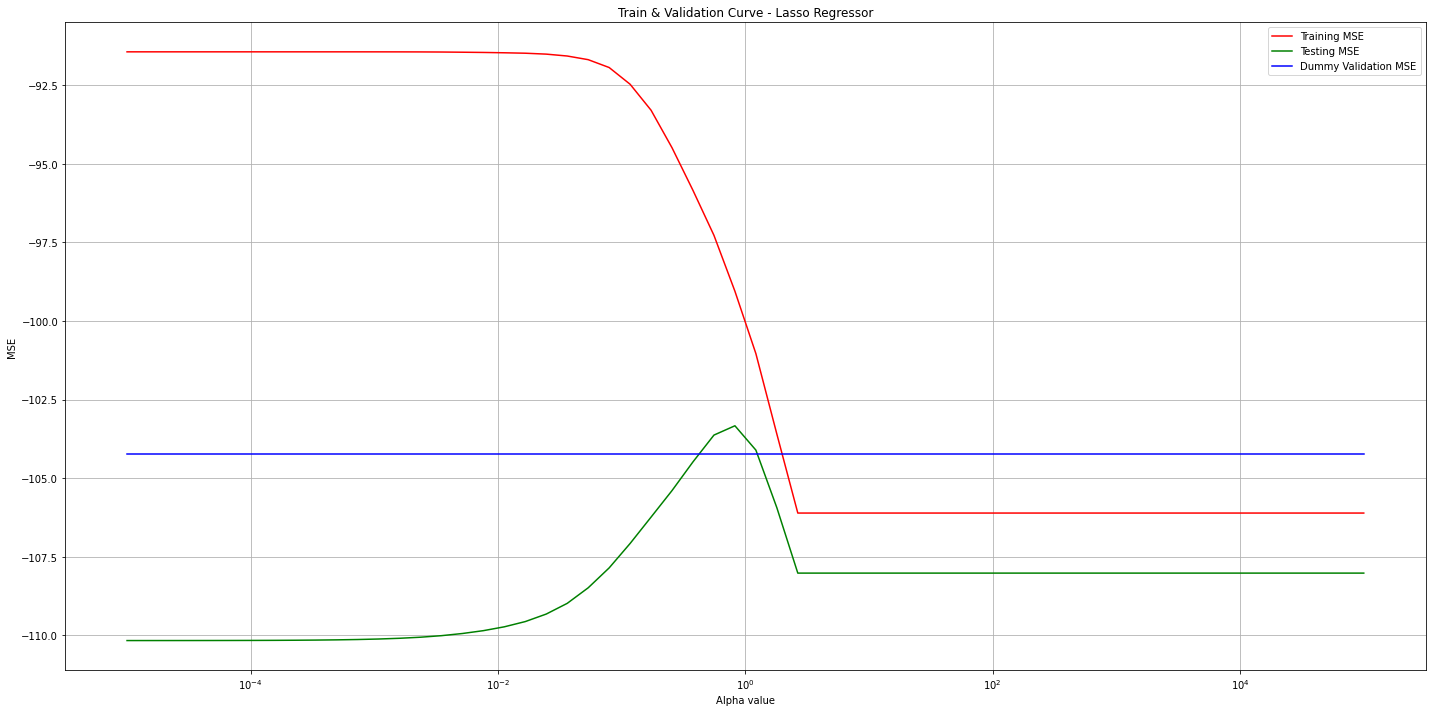

In [ ]:
from sklearn.linear_model import Lasso

X_train = prep_train.copy()
X_train.drop(["contamination_level"], inplace=True, axis=1)
y_train = np.array(prep_train.contamination_level)

train_list, test_list = [], []
rng = np.logspace(-5, 5, 60)

for alpha in rng:
  lreg = Lasso(alpha=alpha, fit_intercept=True)
  cv = cross_validate(estimator=lreg, X=X_train, y=y_train, cv=2, return_train_score=True, scoring='neg_mean_squared_error')
  train_list.append(cv['train_score'].mean())
  test_list.append(cv['test_score'].mean())

plt.figure(figsize=(20,10))
plt.plot(rng, train_list, label="Training MSE", color="red")
plt.plot(rng, test_list, label="Testing MSE", color="green")
plt.plot(rng, [cv_dummy_va for _ in rng], label="Dummy Validation MSE", color="blue")
plt.semilogx()
plt.title("Train & Validation Curve - Lasso Regressor")
plt.xlabel("Alpha value")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.show()

Lets zoon in:

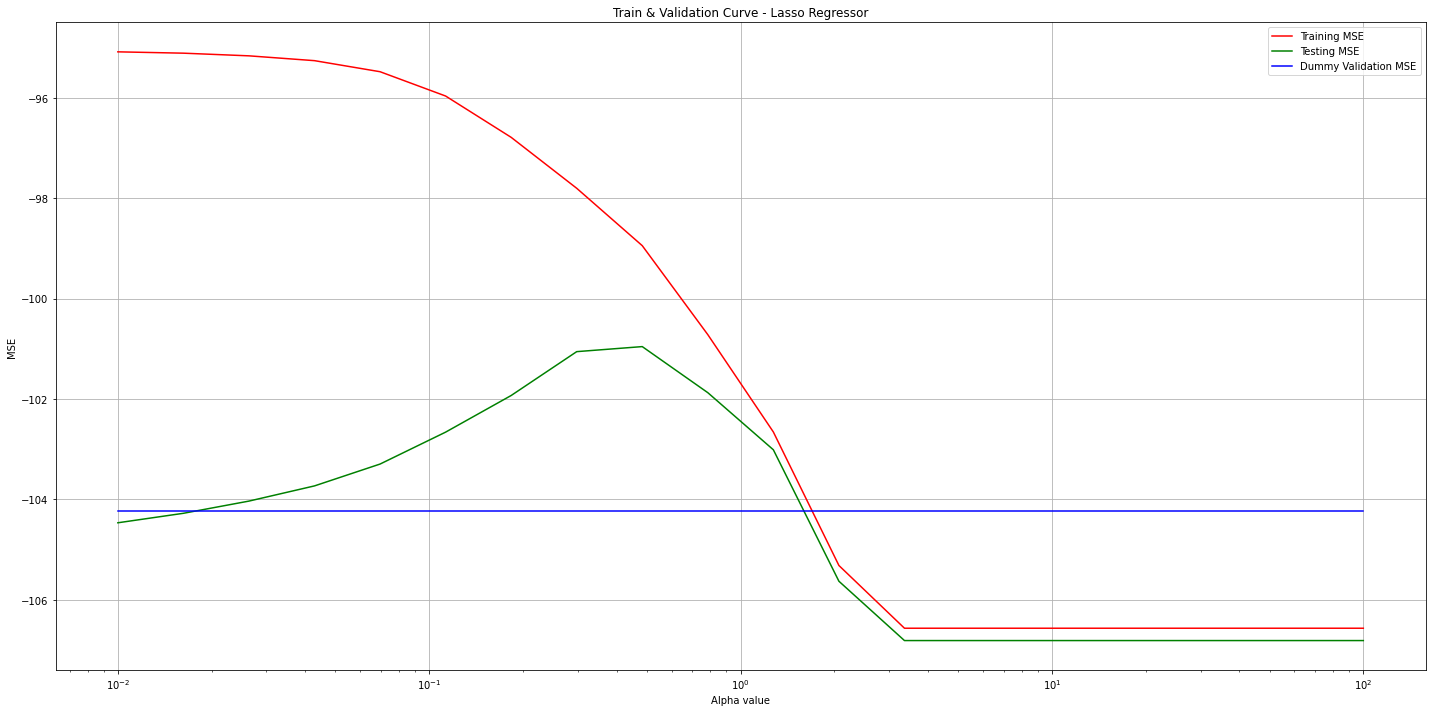

In [ ]:
from sklearn.linear_model import Lasso

X_train = prep_train.copy()
X_train.drop(["contamination_level"], inplace=True, axis=1)
y_train = np.array(prep_train.contamination_level)

train_list, test_list = [], []
rng = np.logspace(-2, 2, 20)

for alpha in rng:
  lreg = Lasso(alpha=alpha, fit_intercept=True)
  cv = cross_validate(estimator=lreg, X=X_train, y=y_train, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
  train_list.append(cv['train_score'].mean())
  test_list.append(cv['test_score'].mean())

plt.figure(figsize=(20,10))
plt.plot(rng, train_list, label="Training MSE", color="red")
plt.plot(rng, test_list, label="Testing MSE", color="green")
plt.plot(rng, [cv_dummy_va for _ in rng], label="Dummy Validation MSE", color="blue")
plt.semilogx()
plt.title("Train & Validation Curve - Lasso Regressor")
plt.xlabel("Alpha value")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.show()

### Question 8 - LassoRegressor with the tuning lr

In [ ]:
print(f"Best Alpha: {rng[np.argmax(test_list)]}")
print(f"Best Alpha mean train accuracy: {train_list[np.argmax(test_list)]}")
print(f"Best Alpha mean test/validation accuracy: {test_list[np.argmax(test_list)]}")

Best Alpha: 0.4832930238571752
Best Alpha mean train accuracy: -98.94466000643561
Best Alpha mean test/validation accuracy: -100.95495698601545


In [ ]:
alpha = 0.48
X_train = prep_train.copy()
X_train.drop(["contamination_level"], inplace=True, axis=1)
y_train = np.array(prep_train.contamination_level)

lreg = Lasso(alpha=alpha)
cv = cross_validate(estimator=lreg, X=X_train, y=y_train, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
cv_dummy_va = cv['test_score'].mean()
print(f"Train Error {cv['train_score'].mean()}")
print(f"Validation Error {cv['test_score'].mean()}")

Train Error -98.92416946867455
Validation Error -100.9498447749211


LassoRegressor for Section 6 

In [ ]:
X_train = prep_train.copy()
X_train.drop(["contamination_level"], inplace=True, axis=1)
y_train = np.array(prep_train.contamination_level)

lasso_reg = Lasso(alpha=alpha)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.48)

### Question 9 -  largest coefficients (in absolute value) in the resulting regressor

In [ ]:
lasso_coefs = {}
for i, label in enumerate(X_train.columns):
    lasso_coefs[label] = abs(lasso_reg.coef_[i])

lasso_coefs = {k: v for k, v in sorted(lasso_coefs.items(), key=lambda item: -item[1])}
print(lasso_coefs)

{'sugar_levels': 1.8538434051957786, 'PCR_01': 1.324179994010843, 'blood_group_O': 0.007620123754649059, 'patient_id': 0.0, 'age': 0.0, 'sex': 0.0, 'weight': 0.0, 'num_of_siblings': 0.0, 'happiness_score': 0.0, 'household_income': 0.0, 'conversations_per_day': 0.0, 'sport_activity': 0.0, 'PCR_02': 0.0, 'PCR_03': 0.0, 'PCR_04': 0.0, 'PCR_05': 0.0, 'PCR_06': 0.0, 'PCR_07': 0.0, 'PCR_08': 0.0, 'PCR_09': 0.0, 'PCR_10': 0.0, 'blood_group_A': 0.0, 'blood_group_B/AB': 0.0, 'symptom_cough': 0.0, 'symptom_low_appetite': 0.0, 'symptom_shortness_of_breath': 0.0, 'symptom_sore_throat': 0.0, 'symptom_fever': 0.0, 'x_global_coor': 0.0, 'y_global_coor': 0.0, 'pcr_date_numeric': 0.0}


### Question 10 -  Plotting coefficients

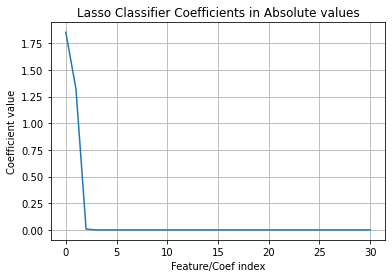

In [ ]:
plt.plot(list(range(len(lasso_coefs.values()))), list(lasso_coefs.values()))
plt.title("Lasso Classifier Coefficients in Absolute values")
plt.xlabel("Feature/Coef index")
plt.ylabel("Coefficient value")
plt.grid()
plt.show()

## Section 4: Polynomial fitting (visualization)

Creating new dataset for the section, containing "PCR_01", "PCR_05", "contamination_level"

In [ ]:
sec4_train = prep_train[["PCR_01", "PCR_05", "contamination_level"]]

### Question 10 - 3-d plot

In [ ]:
def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1, 
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    ax.view_init(elev=5., azim=45*i)
  
  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

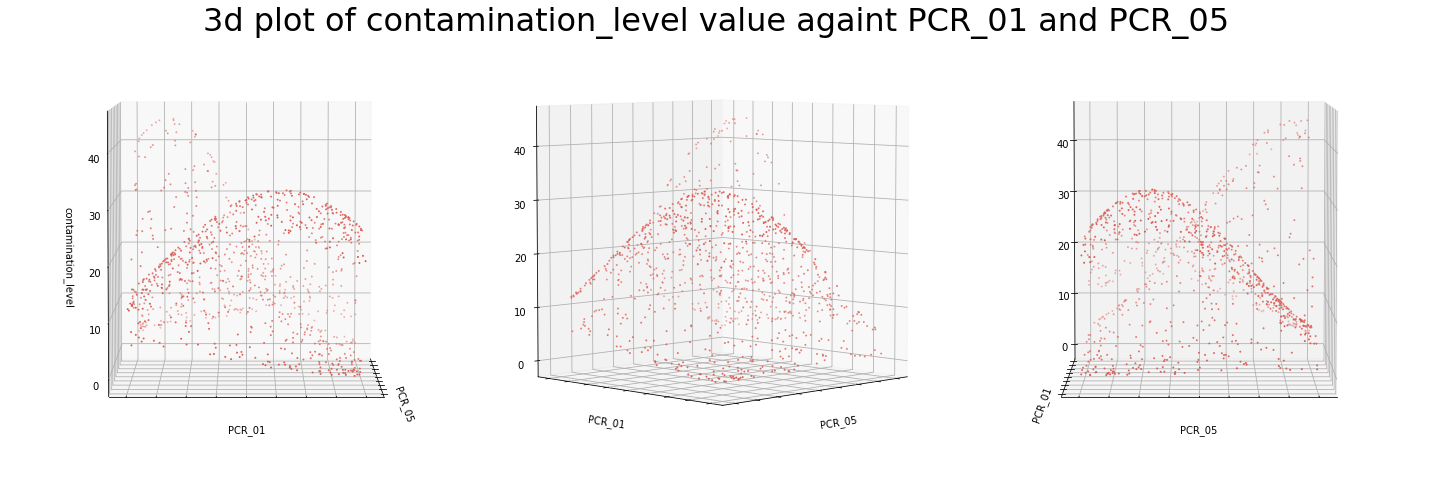

In [ ]:
plot3d(sec4_train, "PCR_05", "PCR_01", "contamination_level", "3d plot of contamination_level value againt PCR_01 and PCR_05")

### Question 14 - Lasso classifier as baseline

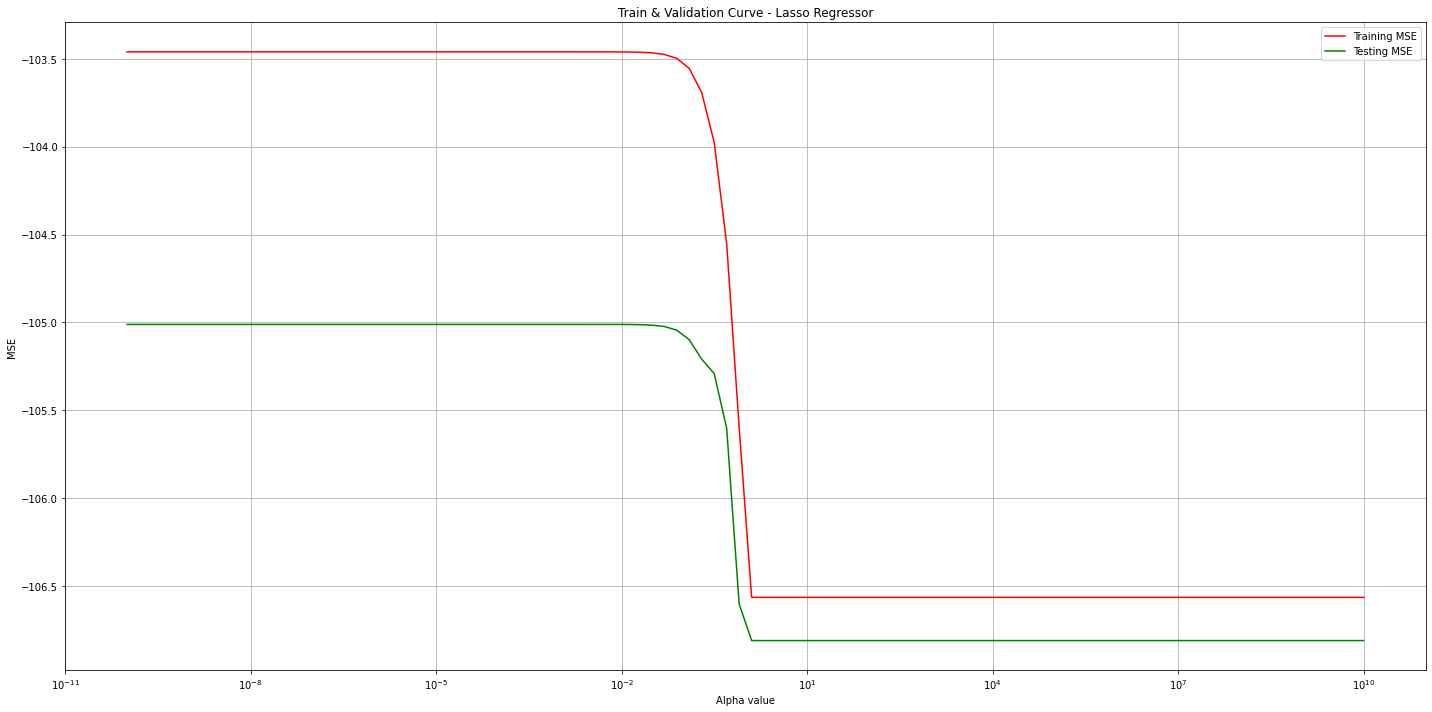

In [ ]:
from sklearn.linear_model import Lasso

X_train = sec4_train.copy()
X_train.drop(["contamination_level"], inplace=True, axis=1)
y_train = np.array(sec4_train.contamination_level)

train_list, test_list = [], []
rng = np.logspace(-10, 10, 100)

for alpha in rng:
  lreg = Lasso(alpha=alpha, fit_intercept=True)
  cv = cross_validate(estimator=lreg, X=X_train, y=y_train, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
  train_list.append(cv['train_score'].mean())
  test_list.append(cv['test_score'].mean())

plt.figure(figsize=(20,10))
plt.plot(rng, train_list, label="Training MSE", color="red")
plt.plot(rng, test_list, label="Testing MSE", color="green")
plt.semilogx()
plt.title("Train & Validation Curve - Lasso Regressor")
plt.xlabel("Alpha value")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.show()

In [ ]:
print(f"Best Alpha: {rng[np.argmax(test_list)]}")
print(f"Best Alpha mean train accuracy: {train_list[np.argmax(test_list)]}")
print(f"Best Alpha mean test/validation accuracy: {test_list[np.argmax(test_list)]}")

Best Alpha: 0.004750810162102793
Best Alpha mean train accuracy: -103.46096206062994
Best Alpha mean test/validation accuracy: -105.01141599450246


In [ ]:
alpha = 0.0
X_train = sec4_train.copy()
X_train.drop(["contamination_level"], inplace=True, axis=1)
y_train = np.array(sec4_train.contamination_level)

lreg = Lasso(alpha=alpha)
cv = cross_validate(estimator=lreg, X=X_train, y=y_train, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
cv_dummy_va = cv['test_score'].mean()
print(f"Train Error {cv['train_score'].mean()}")
print(f"Validation Error {cv['test_score'].mean()}")

Train Error -103.46082304118954
Validation Error -105.01157933732618


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.000e+04, tolerance: 8.191e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet

In [ ]:
X_train = sec4_train.copy()
X_train.drop(["contamination_level"], inplace=True, axis=1)
y_train = np.array(sec4_train.contamination_level)

sec4_lasso_reg = Lasso(alpha=alpha)
sec4_lasso_reg.fit(X_train, y_train)

<ipython-input-32-2ab0c8102bde>:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  sec4_lasso_reg.fit(X_train, y_train)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.181e+04, tolerance: 1.066e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.0)

### Question 15 - 3d plot of thr Lasso baseline

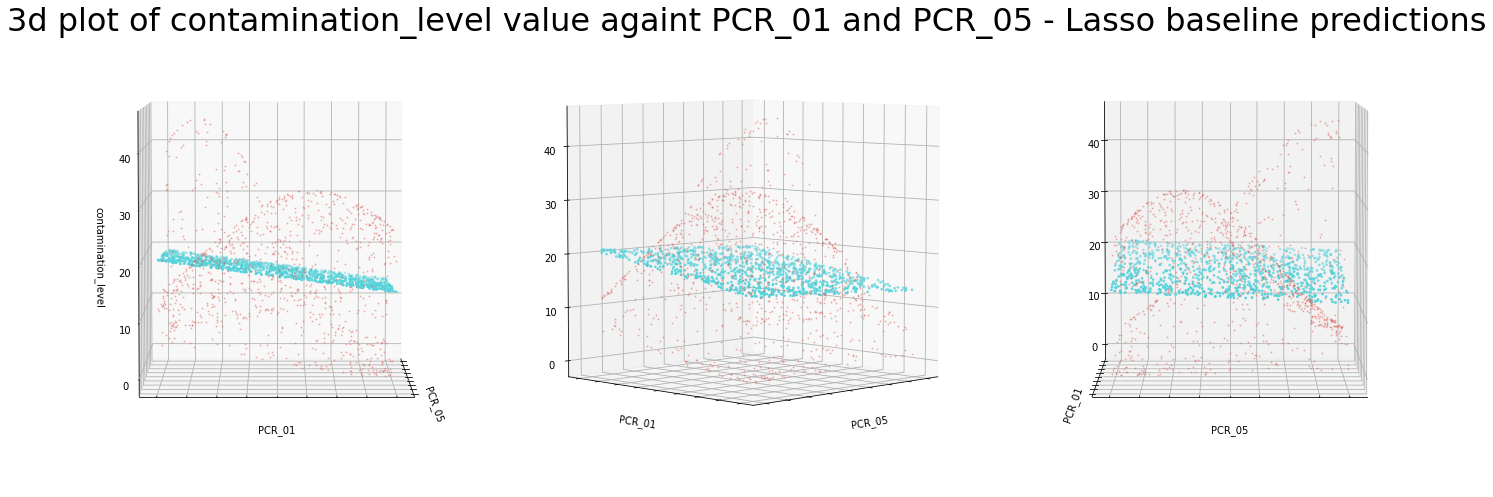

In [ ]:
plot3d(sec4_train, "PCR_05", "PCR_01", "contamination_level", "3d plot of contamination_level value againt PCR_01 and PCR_05 - Lasso baseline predictions", predictions=sec4_lasso_reg.predict(X_train))

### Question 17 - Lasso regressor with the polynomial mapping using cross validation

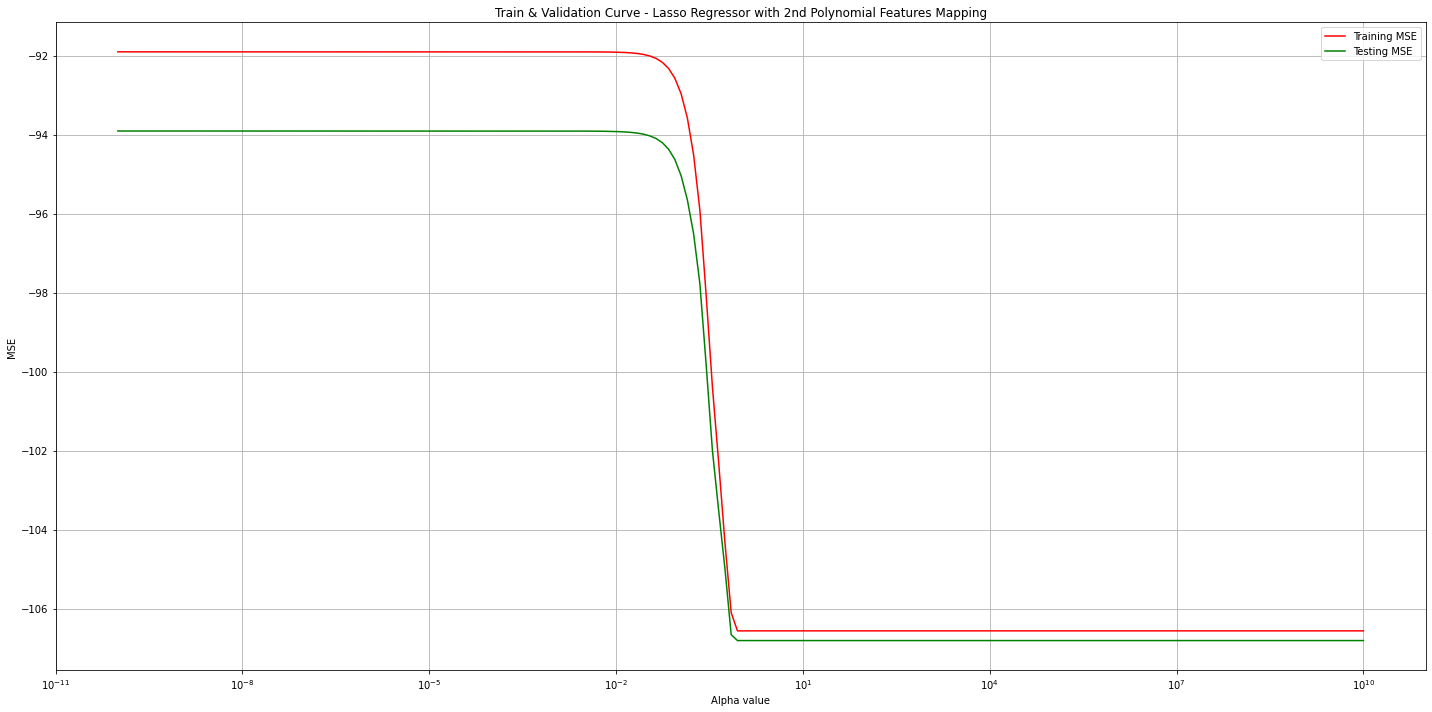

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

X_train = sec4_train.copy()
X_train.drop(["contamination_level"], inplace=True, axis=1)
y_train = np.array(sec4_train.contamination_level)

train_list, test_list = [], []
rng = np.logspace(-10, 10, 200)

for alpha in rng:
  poly_reg = Pipeline([('feature_mapping', PolynomialFeatures(degree=2)),
                     ('normalization', MinMaxScaler()),
                     ('Lasso', Lasso(alpha=alpha, fit_intercept=True))])

  cv = cross_validate(estimator=poly_reg, X=X_train, y=y_train, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
  train_list.append(cv['train_score'].mean())
  test_list.append(cv['test_score'].mean())

plt.figure(figsize=(20,10))
plt.plot(rng, train_list, label="Training MSE", color="red")
plt.plot(rng, test_list, label="Testing MSE", color="green")
plt.semilogx()
plt.title("Train & Validation Curve - Lasso Regressor with 2nd Polynomial Features Mapping")
plt.xlabel("Alpha value")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.show()

In [ ]:
print(f"Best Alpha: {rng[np.argmax(test_list)]}")
print(f"Best Alpha mean train accuracy: {train_list[np.argmax(test_list)]}")
print(f"Best Alpha mean test/validation accuracy: {test_list[np.argmax(test_list)]}")

Best Alpha: 1e-10
Best Alpha mean train accuracy: -91.90228071421694
Best Alpha mean test/validation accuracy: -93.90707122460624


In [ ]:
alpha = 1e-10
X_train = sec4_train.copy()
X_train.drop(["contamination_level"], inplace=True, axis=1)
y_train = np.array(sec4_train.contamination_level)

poly_reg = Pipeline([('feature_mapping', PolynomialFeatures(degree=2)),
                     ('normalization', MinMaxScaler()),
                     ('Lasso', Lasso(alpha=alpha, fit_intercept=True))])

cv = cross_validate(estimator=poly_reg, X=X_train, y=y_train, cv=5, return_train_score=True, scoring='neg_mean_squared_error')
cv_dummy_va = cv['test_score'].mean()
print(f"Train Error {cv['train_score'].mean()}")
print(f"Validation Error {cv['test_score'].mean()}")

Train Error -91.90228071421694
Validation Error -93.90707122460624


### Question 18 - 3d plot of the Lasso with 2nd Polynomial Features Mapping

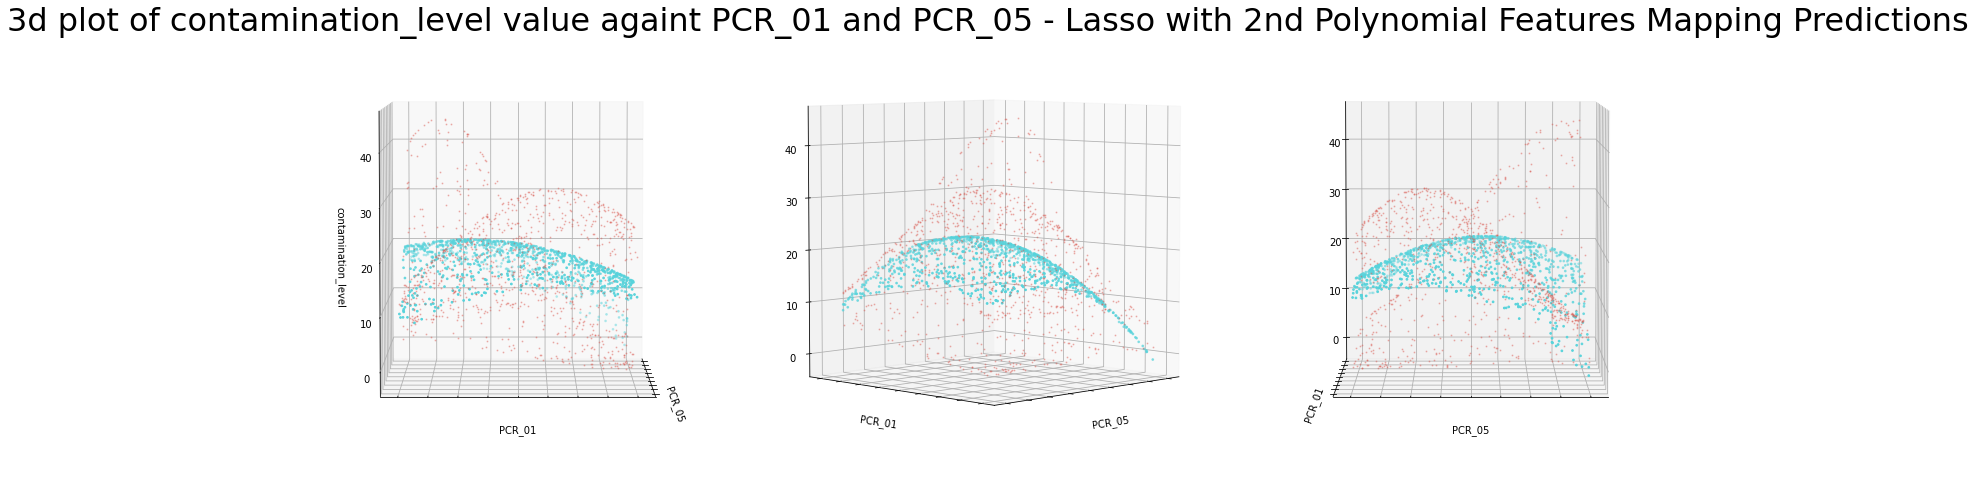

In [ ]:
poly_reg.fit(X_train, y_train)
plot3d(sec4_train, "PCR_05", "PCR_01", "contamination_level", "3d plot of contamination_level value againt PCR_01 and PCR_05 - Lasso with 2nd Polynomial Features Mapping Predictions", predictions=poly_reg.predict(X_train))

## Section 5: RandomForest fitting of the CovidScore

In [ ]:
sec5_train = prep_train.copy()
sec5_test = prep_test.copy()

### Question 23 - RandomForest cross validation

best estimator: Pipeline(steps=[('feature_mapping',
                 ColumnTransformer(transformers=[('rbf',
                                                  RBFSampler(gamma=0.05,
                                                             random_state=80),
                                                  ['PCR_05', 'PCR_01'])])),
                ('RandomForestRegressor',
                 RandomForestRegressor(min_samples_leaf=13, n_estimators=48))])


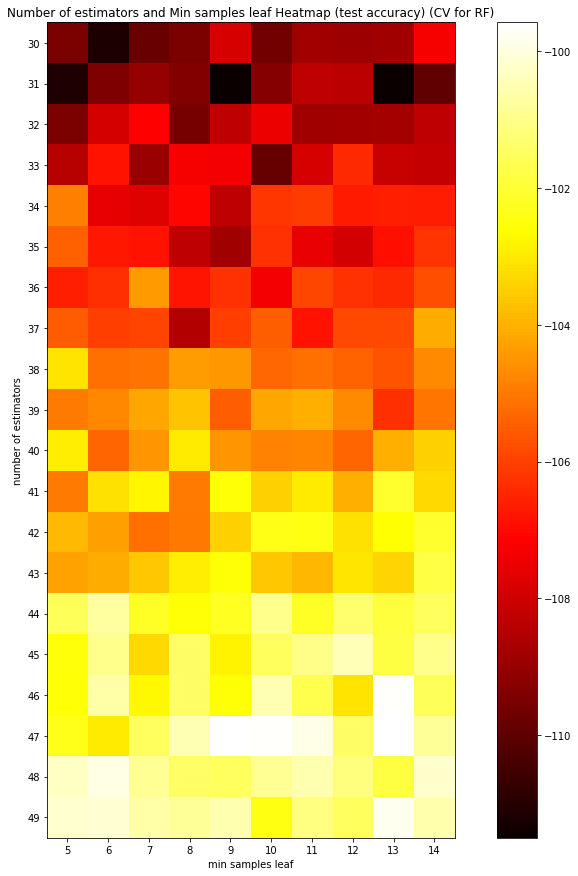

In [ ]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

ct = ColumnTransformer([
    ("rbf", RBFSampler(gamma=0.05, n_components=100, random_state=random_state), ["PCR_05", "PCR_01",]),
    #("3rd_pol", PolynomialFeatures(degree=3), ["PCR_01", "PCR_02"]),
])

X_train = sec5_train.copy()
X_train.drop(["contamination_level"], inplace=True, axis=1)
y_train = np.array(sec5_train.contamination_level)

rf = Pipeline([
                     ('feature_mapping', ct),
                     ('RandomForestRegressor', RandomForestRegressor())])

n_estimators_range = list(range(30, 50))
min_samples_leaf_range = list(range(5, 15))
parameters = {'RandomForestRegressor__n_estimators':n_estimators_range, 'RandomForestRegressor__min_samples_leaf':min_samples_leaf_range}

clf = GridSearchCV(rf, parameters, cv=2, return_train_score=True, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)
print(f"best estimator: {clf.best_estimator_}")

scores = clf.cv_results_['mean_test_score'].reshape(len(n_estimators_range),len(min_samples_leaf_range))
plt.figure(figsize=(15, 15))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('min samples leaf')
plt.ylabel('number of estimators')
plt.colorbar()
plt.xticks(np.arange(len(min_samples_leaf_range)), min_samples_leaf_range)
plt.yticks(np.arange(len(n_estimators_range)), n_estimators_range)
plt.title('Number of estimators and Min samples leaf Heatmap (test accuracy) (CV for RF)')
plt.show()

In [ ]:
ct = ColumnTransformer([
    ("rbf", RBFSampler(gamma=0.01, n_components=100, random_state=random_state), ["PCR_05", "PCR_01",]),
])

X_train = sec5_train.copy()
X_train.drop(["contamination_level"], inplace=True, axis=1)
y_train = np.array(sec5_train.contamination_level)

rf = Pipeline([
                     ('feature_mapping', ct),
                     ('RandomForestRegressor', RandomForestRegressor(n_estimators=48, max_leaf_nodes=13))])

cv = cross_validate(estimator=rf, X=X_train, y=y_train, cv=2, return_train_score=True, scoring='neg_mean_squared_error')
cv_dummy_va = cv['test_score'].mean()
print(f"Train Error {cv['train_score'].mean()}")
print(f"Validation Error {cv['test_score'].mean()}")


Train Error -56.71396380793637
Validation Error -99.81418085154874


RandomForestRegressor for Section 6 

In [ ]:
ct = ColumnTransformer([
    ("rbf", RBFSampler(gamma=0.01, n_components=100, random_state=random_state), ["PCR_05", "PCR_01",]),
])

X_train = sec5_train.copy()
X_train.drop(["contamination_level"], inplace=True, axis=1)
y_train = np.array(sec5_train.contamination_level)

rf_reg = Pipeline([
                     ('feature_mapping', ct),
                     ('RandomForestRegressor', RandomForestRegressor(n_estimators=48, max_leaf_nodes=13))])

rf_reg.fit(X_train, y_train)

Pipeline(steps=[('feature_mapping',
                 ColumnTransformer(transformers=[('rbf',
                                                  RBFSampler(gamma=0.01,
                                                             random_state=80),
                                                  ['PCR_05', 'PCR_01'])])),
                ('RandomForestRegressor',
                 RandomForestRegressor(max_leaf_nodes=13, n_estimators=48))])

## Section 6: Testing your models

In [ ]:
from sklearn.metrics import mean_squared_error

models = [dummy_reg, linear_reg, lasso_reg, rf_reg]
test_mses = []

X_test = prep_test.copy()
X_test.drop(["contamination_level"], inplace=True, axis=1)
y_test = np.array(prep_test.contamination_level)

for model in models:
    y_pred = model.predict(X_test)
    test_mses.append(-mean_squared_error(y_test, y_pred))

test_mses

[-112.39781926156763,
 -104.12642996335445,
 -103.20570953774586,
 -90.53704831045962]

Dummy:
Train Error -106.5640324839979
Validation Error -106.80977716784801

Linear:
Train Error -95.584746095732
Validation Error -104.22744256883104

Lasso:
Train Error -98.92416946867455
Validation Error -100.9498447749211

RandomForestRegressor:
Train Error -56.71396380793637
Validation Error -99.81418085154874

[-112.39781926156763,
 -104.12642996335445,
 -103.20570953774586,
 -90.53704831045962]
